In [1]:
%pylab inline

from PIL import Image
import os
import pandas as pd
import pylab as pl

from time import time

import numpy as np
import pandas as pd
import pylab as pl
from sklearn import (cluster, datasets, decomposition, ensemble, manifold, random_projection)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from mpl_toolkits.mplot3d import Axes3D # needed to modify the way figure behaves

Populating the interactive namespace from numpy and matplotlib


In [2]:

def load_images(img_dir, grayscale=False):
    """Loads images from within a specified directory.

    Args:
      img_dir (str): The directory from which to load (.jpg) images.
      grayscale (bool): Whether to convert the image into grayscale. Defaults to False.

    Returns:
      images: An array of image objects loaded from the specified directory

    """
    images = []

    for file in os.listdir(img_dir):
        if file.endswith(".jpg"):
            im = Image.open(os.path.join(img_dir, file))

            im = im.resize((100, 100))

            if grayscale:
                im = np.array(im, dtype=np.float64) / 255

                # Convert image to grayscale
                r, g, b = im[:,:,0], im[:,:,1], im[:,:,2]
                gray = 0.2989*r + 0.5870*g + 0.1140*b
                im = gray.reshape((1, -1))[0]

            images.append(im)

    return images

def plot_image_space(images, X, title="Projection of the Images into 2 Dimensions"):
    """Generates and shows a plot of images in a feature space.

    A figure with one plot is generated. The plot displays the location of each image in 
    relation to the image's feature values in the input feature space (X).

    Args:
      images (Image): An image.
      images (SciPy array): An array of SSQs, one computed for each k.

    """
    # min-max normalization    
    x_min, x_max = np.min(X, axis=0), np.max(X, axis=0)
    X = (X - x_min) / (x_max - x_min)

    # Create a figure
    pl.figure(figsize=(16, 5))
    ax = pl.subplot(111)
    #ax.axis('off')

    # Generate picture thumbnails in the plot
    if hasattr(matplotlib.offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        for i in range(len(images)):
            imagebox = matplotlib.offsetbox.OffsetImage(images[i], zoom=.65)
            ab = matplotlib.offsetbox.AnnotationBbox(imagebox, X[i][0:2])                                  
            ax.add_artist(ab)

    # Add figure labels and ticks
    pl.title(title, fontsize=16)
    pl.xticks([]), pl.yticks([])

    # Add figure bounds
    pl.ylim((np.min(X, axis=0)[1])-0.25,(np.max(X, axis=0)[1])+0.25)
    pl.xlim((np.min(X, axis=0)[0])-0.1,(np.max(X, axis=0)[0])+0.1)

In [3]:
img_dir = os.path.join(os.getcwd(), "./images") # directory path
images = load_images(img_dir) # load images in the specified directory

In [4]:
X = pd.DataFrame([im.histogram() for im in images])

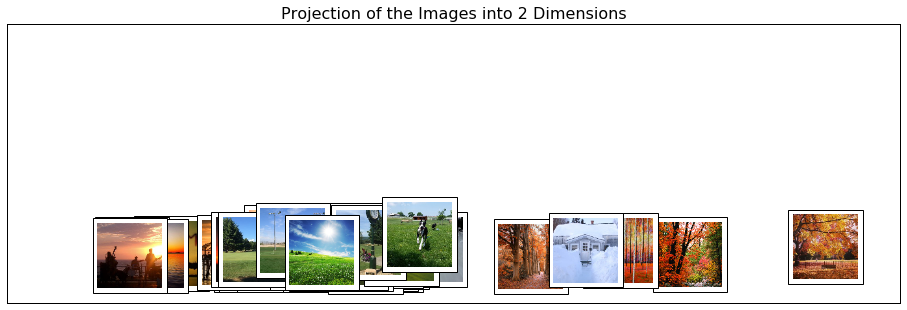

In [9]:
plot_image_space(images, X)

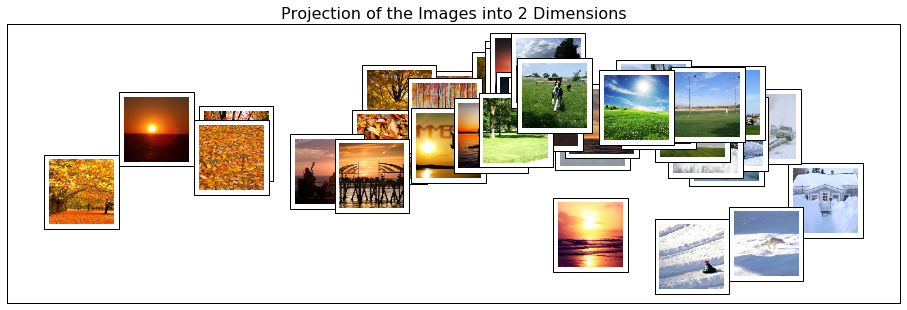

In [23]:
# Projection onto the first 2 principal components using PCA

# global centering
X_centered = X - X.mean()
    
pca = decomposition.PCA(n_components=2)
X_pca = pca.fit_transform(X)

plot_image_space(images, X_pca)

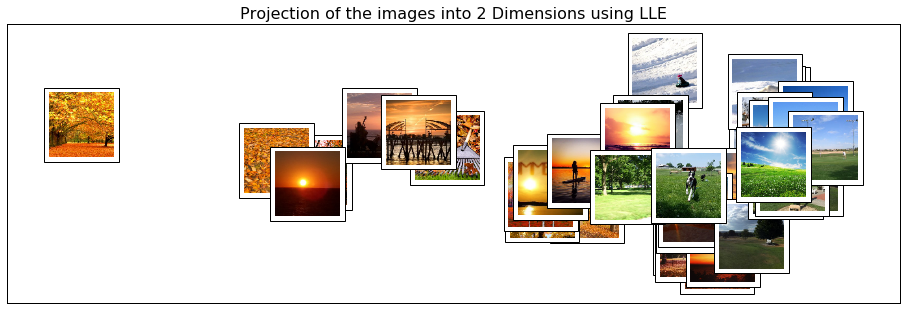

In [7]:
# Compute (two-dimensional) LLE on the season images --- Just for comparison

clf = manifold.LocallyLinearEmbedding(n_neighbors=30, n_components=2, method='standard')
X_lle = clf.fit_transform(X)

plot_image_space(images, X_lle, title="Projection of the images into 2 Dimensions using LLE")


# As you may see, PCA and LLE sort images in a similar way. But in the case of LLE, more images
# are mixed into the right section of the projection, which makes it harder to clearly distinguish
# the summer images from winter images. So in my opinion PCA is giving a more accruate and easy
# to recognize output compared to LLE in this set of season images.

Part 2

Given this output, respond to the following questions:

1. What does it mean for two images to be close together in this plot? What does it mean for two images to be far apart?

From Wikipedia: "Often, PCA operation can be thought of as revealing the internal structure of the data in a way that best explains the variance in the data." 

Since the purpose of PCA is to retain the original information like variabilities of the given images as much as possible, while using the minimum number of principle components; then if two images are close together, it means the variabilities / difference between the two images are relatively small. On the other hand, if two images are far apart, then their difference / variability measured by the 2 principle components are relatively large. 

2. Do images corresponding to one of the seasons tend to group together more closely than others? Why might this be the case?

Yes, it looks like so. On the left side we can see the autumn images are grouped together; on the right side are the winter images mostly. In the middle we can see the summer images and (maybe) some spring images mixed together. 

The reason for such grouping may be the color values of each image. Since the idea is to utilize the color histogram to differentiate between images, images with similar histogram value data will be close to each other, while images with large variance in histogram value data will be separated apart. For example, in the winter season images, most of the images have white background; as a result, the number of white color pixels will be very large and become a dominant factor in the PCA. Same idea applies to the left side where autumn images mostly with brown / yellow color are grouped together.

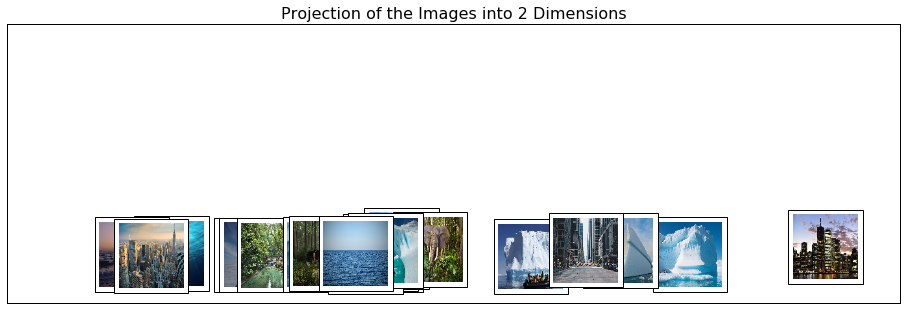

In [36]:
# Part 3 - Images captured from images.google.com

img_dir_landscape = os.path.join(os.getcwd(), "./landscape_dataset") # directory path
images_landscape = load_images(img_dir_landscape) # load images in the specified directory

X_landscape = pd.DataFrame([im.histogram() for im in images])

plot_image_space(images_landscape, X_landscape)

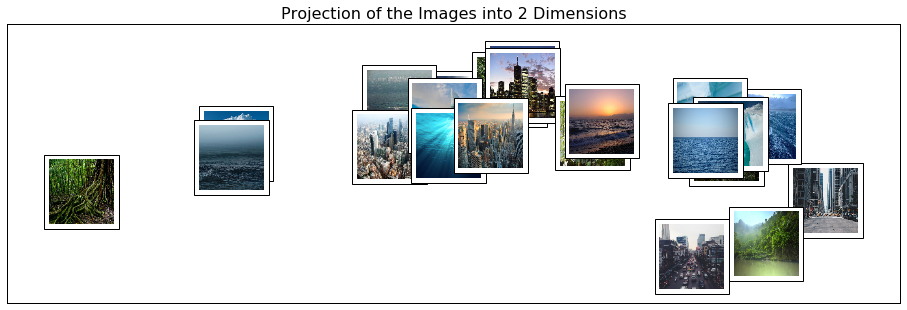

In [37]:
# Projection onto the first 2 principal components
    
pca = decomposition.PCA(n_components=2)
X_landscape_pca = pca.fit_transform(X_landscape)

plot_image_space(images_landscape, X_landscape_pca)

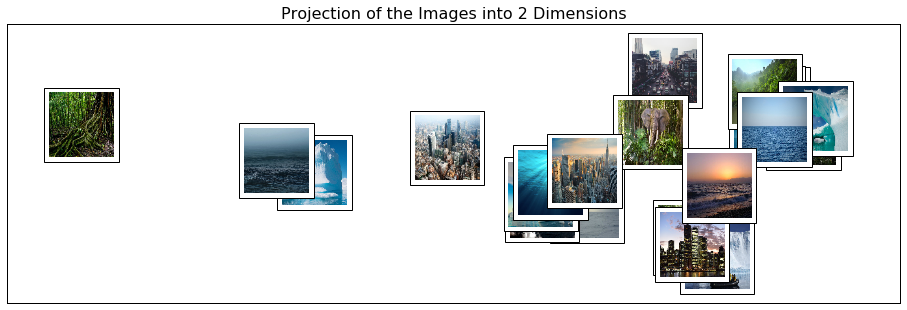

In [38]:
# Compute (two-dimensional) LLE on the landscape images

#print("Computing LLE..."),
clf = manifold.LocallyLinearEmbedding(n_neighbors=30, n_components=2, method='standard')
X_landscape_lle = clf.fit_transform(X_landscape)
#print("done. Reconstruction error: %g" % clf.reconstruction_error_)

plot_image_space(images_landscape, X_landscape_lle)

In the above experiment, I downloaded 28 images in 4 different landscape categories: ocean, jungle, antarctica, and city. Each category has 7 images. My objective is to use 2-dimentional PCA and LLE to capture the variance in those images and see whether any of the algorithm can succesfully differentiate 4 types of images. 

As you may see, the results of applying PCA and LLE are similar. Both algorithms sort the images in an identical way, with the left most image being the green jungle image. In the middle left we can see an ocean image and antartica image. City images are mostly placed on middle right. On the right section are mostly ocean images. 

However, there are still some suggestive differences between the results of PCA and LLE. From the result, you may notice that PCA groups the city images better than LLE. Also, PCA is grouping images with water / ice together more tightly, which makes sense because antarctica images are somewhat similar to ocean images (both have water). On the other hand, LLE struggles a lot more. On the right side of the result, you may see it cannot efficiently identify between ociean images, city images and jungle images. So in my opinion PCA is the clear "winner" in this experiment. It groups images in a more resonable and suggestive way than LLE.

Lastly, I also notice that both PCA and LLE struggles on the jungle images, which in my opinion should be the easiest set of images to differentiate (all green pixels). In both case the jungle images are scattered / mixed within other types of images, and also there's one jungle image placed on the left most side. I think it may because of the color values of jungle images are more complicated than I thought. Some images may contain a variety of color pixels even if it looks like green mostly. Still I'm not so sure about the reason, but for sure it's an interesting observation that worth wondering about.